### Principal Component Analysis (PCA) and Kmeans Clustering of Green House Gas Emissions by Country


Green house gas emmissions have garnered significant attention recently due to it's contribution to climate change, this analysis focuses on categorizing countries based on their GHG emmissions and key economic factors including GDP, Population, Industry Value and Regulatory Quality for 2023. Principal Component Analysis (PCA) and K-Means clustering were employed to group the countries into several categories based on their Emmission and Economic indicators 

The dataset used  for this analysis was sourced from: 
* Emissions Database for Global Atmospheric Research (EDGAR), the data is available at https://edgar.jrc.ec.europa.eu/report_2024 and
* World Bank Development Indicators: https://databank.worldbank.org/source/world-development-indicators#

The Dataset was cleaned and merged using excel into a new notebook WORLDDATA

First, we import the required libraries

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings 
warnings.filterwarnings("ignore")

In [11]:
# Load the dataset

data = pd.read_excel(data/WORLD DATA.xlsx')

df = data.dropna()
df = df.reset_index(drop=True)

# View the data
print('rows,column:',df.shape)
print(df.head())

rows,column: (165, 7)
  Country Code               Country  GHG EMISSION           GDP  \
0          AFG           Afghanistan     29.460052  1.723305e+10   
1          AGO                Angola     67.700756  8.482465e+10   
2          ALB               Albania      7.673672  2.354718e+10   
3          ARE  United Arab Emirates    267.823194  5.141304e+11   
4          ARG             Argentina    365.684619  6.460753e+11   

       Industry  Population   Regulatory Quality  
0  2.330443e+09     41454761            0.219980  
1  3.839411e+10     36749906            0.208203  
2  5.420201e+09      2745972            0.225276  
3  2.453618e+11     10483751            0.215121  
4  1.618831e+11     45538401            0.215121  


We check for skewness before carrying out our analysis as PCA sensitive to skewness

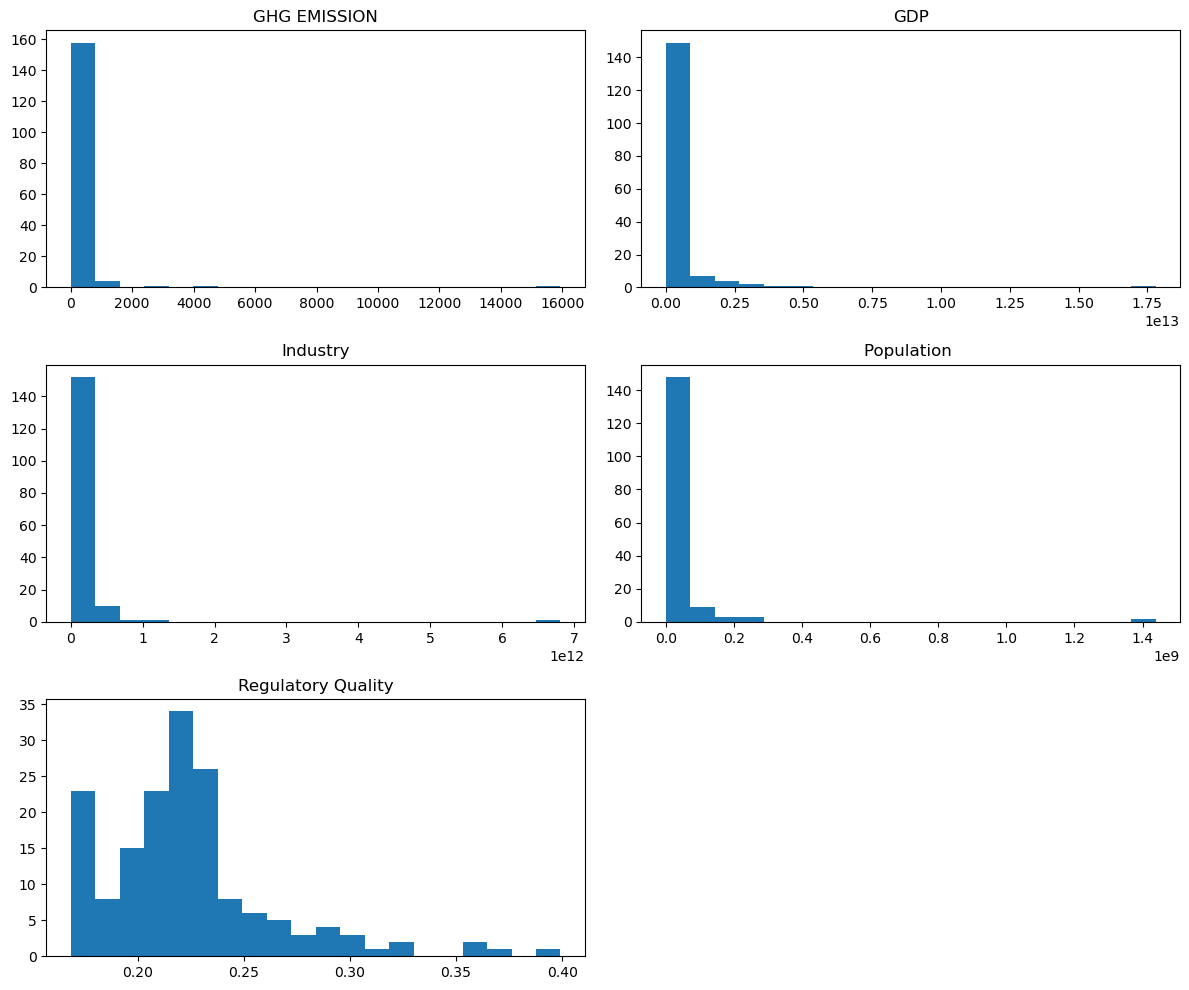

In [14]:
# Check for skewness

df_skew = df.drop(columns=['Country', 'Country Code'])
ax = df_skew.hist(bins=20, figsize=(12, 10))
plt.tight_layout()
for axis in ax.flatten():
    axis.grid(False)
plt.show()
plt.show()

The data is highly skewed so we apply a logarithmic transformation to reduce skewness and stabilize the variance, we then standardize the data to ensure all features have equal weighting and also check for correlation between variables.

In [17]:
# Apply logarithmic transformation
df_log = np.log1p(df.drop(columns=['Country','Country Code']))

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_log)

#convert the data to a dataframe
df_scaled = pd.DataFrame(data_scaled, columns=df_log.columns)

# Check for Correlation
correlation = df_scaled.corr()
print(correlation.head())

                    GHG EMISSION       GDP  Industry  Population   \
GHG EMISSION            1.000000  0.898962  0.913169     0.877290   
GDP                     0.898962  1.000000  0.980236     0.757584   
Industry                0.913169  0.980236  1.000000     0.766489   
Population              0.877290  0.757584  0.766489     1.000000   
Regulatory Quality     -0.355017 -0.210947 -0.234712    -0.639096   

                    Regulatory Quality  
GHG EMISSION                 -0.355017  
GDP                          -0.210947  
Industry                     -0.234712  
Population                   -0.639096  
Regulatory Quality            1.000000  


The data exhibits high correlation so we will apply PCA to reduce dimensionality while retaining the key variance. First we will determine the optimal number of principal components based on the cumulative explained variance.

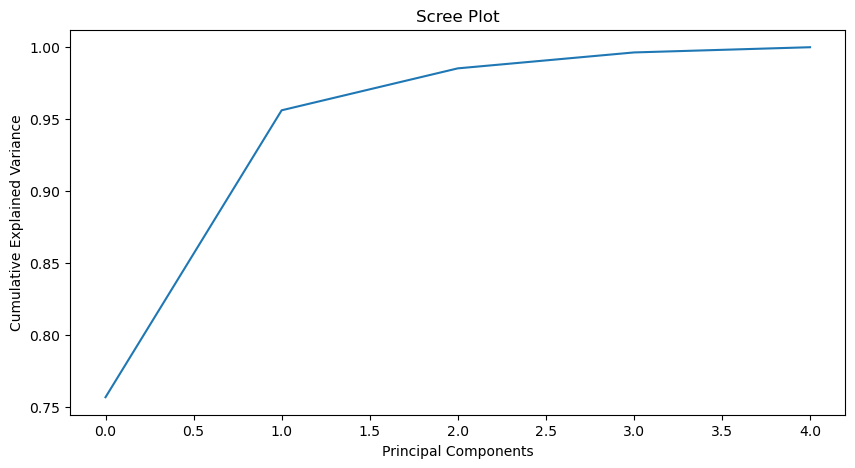

In [20]:
# Fit PCA
pca = PCA()
pca.fit(df_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

Based on the Scree Plot, the optimal number of principal components to retain is 3, we apply PCA with 3 components visualize the variance and draw a heatmap to view the components of the loadings before proceeding with further analysis (Clustering).

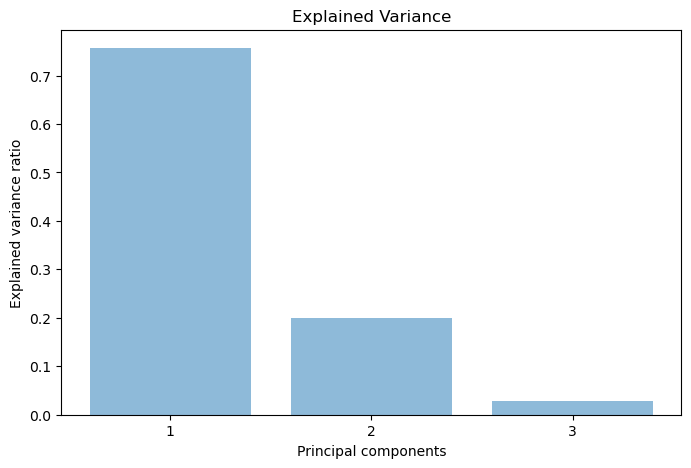

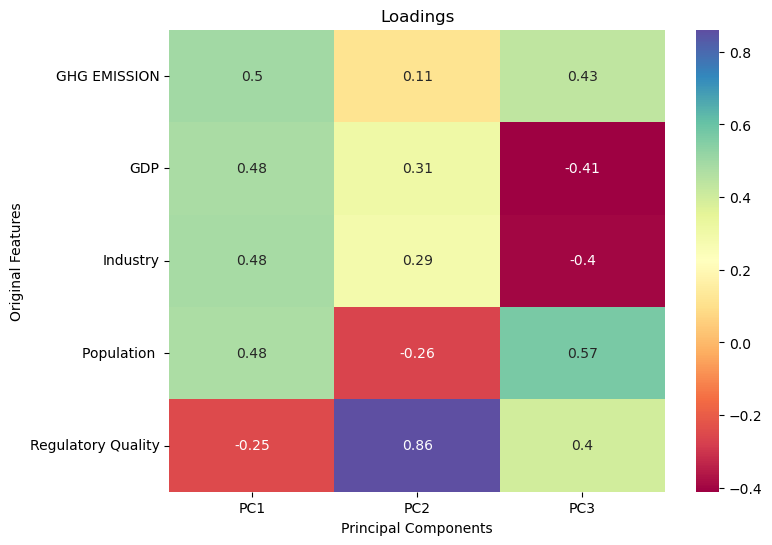

In [23]:
# Optimal number of Components
no_pca = 3

# Apply PCA
pca = PCA(n_components=no_pca)
principal_components = pca.fit_transform(df_scaled)



# Create a DataFrame with the components
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' 
                for i in range(1, no_pca+1)]
)

# Extract the loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2', 'PC3'],
                        index=df_log.columns)
# View the explained variance
explained_variance = pca.explained_variance_ratio_


# Visualize explained variance
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(range(1, len(explained_variance) + 1))
plt.title('Explained Variance')
plt.show()

# Step 7: Visualize loadings heatmap
plt.figure(figsize=(8,6))
sns.heatmap(loadings, annot=True, cmap='Spectral')
plt.title('Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()



The three principal components captures 100% of the variance in the data, lo0king at the heatmap we can see that 

* PC1 captures significant variance in GHG EMISSION, GDP, Industry, and Population.
* PC2 captures more of Regulatory Quality and moderately captures GDP and Industry.
* PC3 captures Population and moderately captures GHG EMISSION and Regulatory Quality with a negative correlation to GDP and industry

For the clustering analysis we will use the K-Means method. To determine the optimal number of clusters, we will compare results using both the silhouette score and the elbow method.

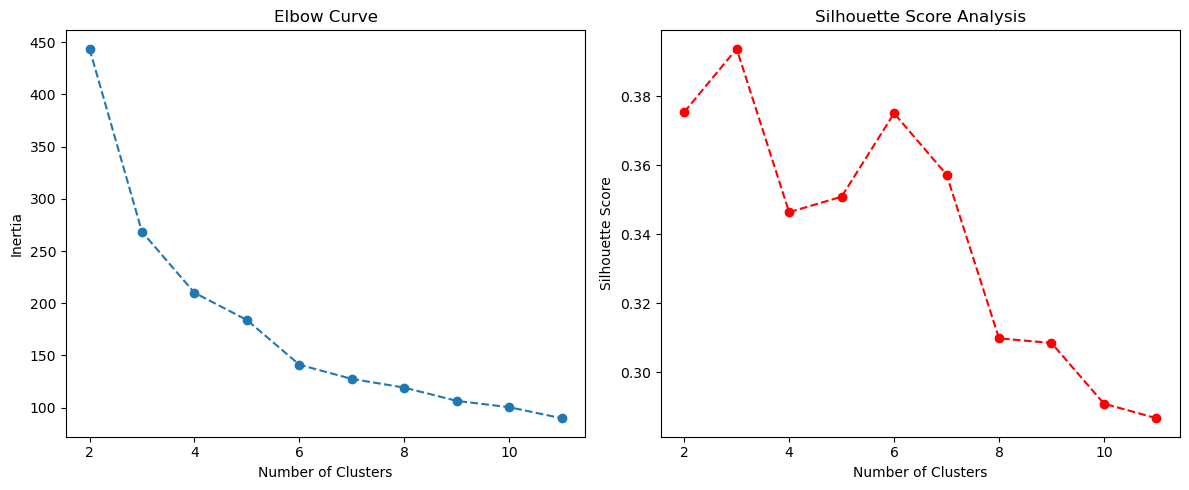

In [27]:
# Initialize the lists
inertia = []
silhouette_scores = []

#loop over range of clusters and append the lists
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=40)
    cluster_labels = kmeans.fit_predict(principal_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(principal_df, cluster_labels))

# Plot Elbow Curve and Silhouette Score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 12), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')

plt.subplot(1, 2, 2)
plt.plot(range(2, 12), silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis')

plt.tight_layout()
plt.show()

The elbow method suggests an optimal number of clusters k to be 4 while the silhouette score analysis suggests an optimal number of clusters k to be 3. Let's compare the silhouette scores for both k = 4 and k = 3.

In [29]:
# Based on the elbow method
optimal_k_elbow = 4
kmeans_elbow = KMeans(n_clusters=optimal_k_elbow, random_state=40)
cluster_labels_elbow = kmeans_elbow.fit_predict(df_scaled)
principal_df['Cluster_Elbow'] = cluster_labels_elbow

# Calculate silhouette_score for k = 4
silhouette_avg_elbow = silhouette_score(df_scaled, cluster_labels_elbow)
print("The average silhouette score for k=4 (Elbow method) is:", silhouette_avg_elbow)

# Based on the silhouette score method
optimal_k_silhouette = 3
kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=40)
cluster_labels_silhouette = kmeans_silhouette.fit_predict(df_scaled)
principal_df['Cluster_Silhouette'] = cluster_labels_silhouette

# Calculate silhouette_score for k = 3
silhouette_avg_silhouette = silhouette_score(df_scaled, cluster_labels_silhouette)
print("The average silhouette score for k=3 (Silhouette method) is:", silhouette_avg_silhouette)

The average silhouette score for k=4 (Elbow method) is: 0.3056286256278033
The average silhouette score for k=3 (Silhouette method) is: 0.3825278887589015


The silhouette score for the silhouette method is higher therefore we will proceed with silhouette method Optimal K= 3 by renaming cluster_silhouette to Cluster and removing Cluster_elbow

In [32]:
# Rename Cluster_Silhouette to Cluster
principal_df.rename(columns={'Cluster_Silhouette': 'Cluster'}, inplace=True)

# Remove Cluster_Elbow column
principal_df.drop(columns=['Cluster_Elbow'], inplace=True)

Let's look at the descriptive statistics of each cluster

In [34]:
cluster_0 = principal_df[principal_df['Cluster'] == 0]
cluster_1 = principal_df[principal_df['Cluster'] == 1]
cluster_2 = principal_df[principal_df['Cluster'] == 2]

# Show summaries for each cluster
print("Cluster 0 Summary:")
print(cluster_0.describe())

print("\nCluster 1 Summary:")
print(cluster_1.describe())

print("\nCluster 2 Summary:")
print(cluster_2.describe())

Cluster 0 Summary:
             PC1        PC2        PC3  Cluster
count  81.000000  81.000000  81.000000     81.0
mean   -0.331072  -0.605749  -0.042001      0.0
std     0.812363   0.859909   0.332644      0.0
min    -2.286705  -2.020925  -0.948125      0.0
25%    -0.814370  -1.355164  -0.242544      0.0
50%    -0.215223  -0.530050  -0.033954      0.0
75%     0.170595   0.022037   0.129407      0.0
max     1.247883   2.540575   0.911062      0.0

Cluster 1 Summary:
             PC1        PC2        PC3  Cluster
count  59.000000  59.000000  59.000000     59.0
mean    1.853087   0.494487  -0.003358      1.0
std     1.016528   0.564791   0.418675      0.0
min     0.343870  -1.100513  -0.814687      1.0
25%     1.039983   0.162835  -0.323106      1.0
50%     1.712882   0.473160   0.012604      1.0
75%     2.451417   0.941305   0.302753      1.0
max     5.506756   1.616703   0.843198      1.0

Cluster 2 Summary:
             PC1        PC2        PC3  Cluster
count  25.000000  25.000000  

Brief summary of these stat:

* Cluster 0: The mean values of the components (PC1, PC2, and PC3) are negative or near zero, suggests that the cluster is dominated by countries with lower values for these components, PC1 has a relatively wider spread with a standard deviation of 0.812, indicating that there's some diversity in how countries within this cluster score on this principal component. PC2 also has a fairly large standard deviation (0.860), indicating variation along this axis, but its values are primarily negative with some positive outliers.PC3 shows a more concentrated spread with the lowest standard deviation (0.333), meaning that the countries within this cluster are more consistent along this principal component.
* Cluster 1: PC1 is predominantly positive, with a mean of 1.853 and a standard deviation of 1.017, showing that the countries in this cluster have higher scores along this axis.PC2 has a mean of 0.494, indicating that these countries show moderate positive values for this component, though there's a spread (standard deviation of 0.565), meaning some countries have more extreme values. PC3 has a negative mean of -0.003, but it still shows a moderate spread (standard deviation of 0.419), meaning there’s still some variation in these countries' scores on this principal component.
* Cluster 2: PC1 has a negative mean of -3.301, with a large spread (standard deviation of 1.076). This shows that the countries in this cluster have a relatively low score for this component but still vary significantly in this dimension. PC2 has a positive mean of 0.796, with a wide range (standard deviation of 1.058). This suggests that countries in this cluster tend to show moderate to high values for this component, but there's considerable variation. PC3 has a moderate positive mean of 0.144, indicating that the countries in this cluster have generally positive values along this component, though there is variation (standard deviation of 0.426).

Let's look at the cluster matrix adding columns for a clear interpretation, we will also visualize with a heatmap

Cluster Matrix:
Cluster                    0         1         2
GHG EMISSION       -0.254572  0.986481 -1.503283
GDP                -0.345540  1.053769 -1.367346
Industry           -0.297229  1.022363 -1.449754
Population         -0.018584  0.740671 -1.687772
Regulatory Quality -0.454019 -0.042625  1.571616


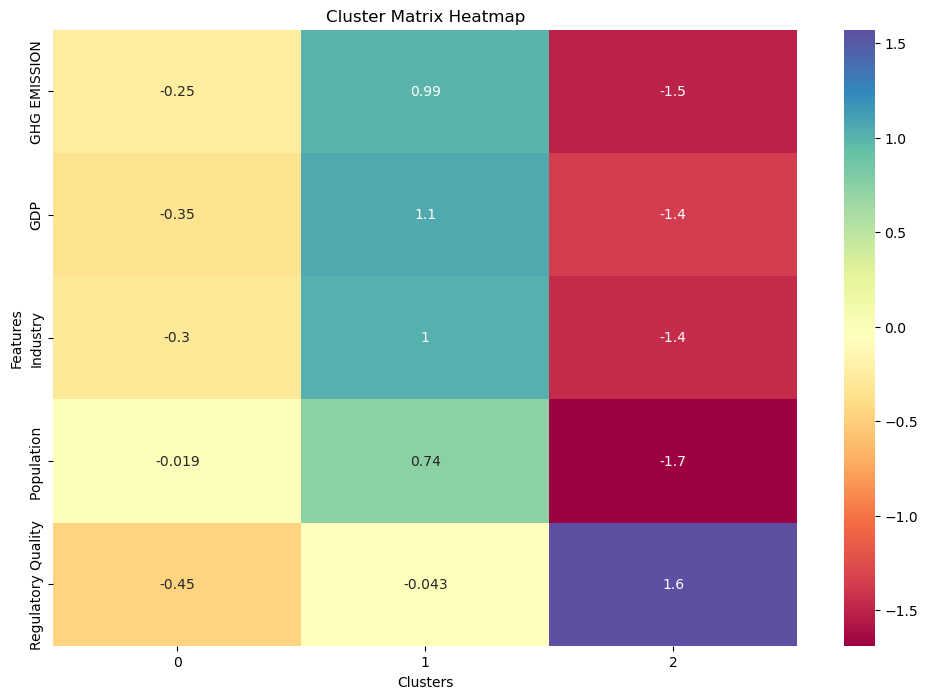

In [38]:
# Append the cluster labels to the scaled DataFrame
df_with_clusters = pd.concat([pd.DataFrame(df_scaled, columns=df_log.columns), 
                              principal_df[['Cluster']]], axis=1)

# Group by clusters and calculate summary statistics
cluster_matrix = df_with_clusters.groupby('Cluster').mean()

# Transpose for better readability
cluster_matrix = cluster_matrix.T

# Display the cluster matrix
print("Cluster Matrix:")
print(cluster_matrix)

# Optional: Visualize the cluster matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_matrix, annot=True, cmap='Spectral')
plt.title('Cluster Matrix Heatmap')
plt.xlabel('Clusters')
plt.ylabel('Features')
plt.show()

* Cluster 0, represents countries with low emissions, low industrial activity, low GDP, and low regulatory quality. These countries are likely economically less developed, with minimal industrial activity and governance. These countries could be emerging or underdeveloped economies with less stringent environmental regulations. We will name them 'Low Emissions, Low Activity Economies'
* Cluster 1 represents countries with high emissions, high GDP, and high industrial activity. These countries are economically developed with significant industrial output, contributing heavily to emissions. Their moderate regulatory quality suggests that while they may have policies in place, they might not be as stringent as those in Cluster 2. This could be a group of developed economies that are major contributors to global emissions. We will name them 'High Emission, Industrial Economies'
* Cluster 2 represents countries with very low emissions and low industrial activity, but they have high regulatory quality, indicating strong governance. These countries may have relatively small populations and economies, but they prioritize regulations. This represents nations with robust regulations despite having lower economic output or industrial activity. These countries might be highly focused on green economies and strong environmental governance. We will name them 'Low Emission, High Regulation Economies'


To visualize the data we will add countries and country codes to our dataframe pricipal_df and add the labels to the dataframe

In [42]:
# Add Country and Country code to the Dataframe
principal_df['Country'] = df['Country']
principal_df['Country Code'] = df['Country Code']

# Label the clusters
cluster_names = { 
    0: 'Low Emissions, Low Activity Economies', 
    1: 'High Emission, Industrial Economies', 
    2: 'Low Emission, High Regulation Economies' 
}

# Map the cluster names to the cluster
principal_df['Cluster Name'] = principal_df['Cluster'].map(cluster_names)
print((principal_df[['Country','Cluster','Cluster Name']]).head(10))

                Country  Cluster                             Cluster Name
0           Afghanistan        0    Low Emissions, Low Activity Economies
1                Angola        0    Low Emissions, Low Activity Economies
2               Albania        0    Low Emissions, Low Activity Economies
3  United Arab Emirates        1      High Emission, Industrial Economies
4             Argentina        1      High Emission, Industrial Economies
5               Armenia        0    Low Emissions, Low Activity Economies
6   Antigua and Barbuda        2  Low Emission, High Regulation Economies
7             Australia        1      High Emission, Industrial Economies
8               Austria        1      High Emission, Industrial Economies
9            Azerbaijan        0    Low Emissions, Low Activity Economies


Next we visualize the data with a scatter plot using the viridis color palette to map cluster_names, the plot will display PC1 on the X axis and PC2 on the Y axis with country codes as annotation for clarity.

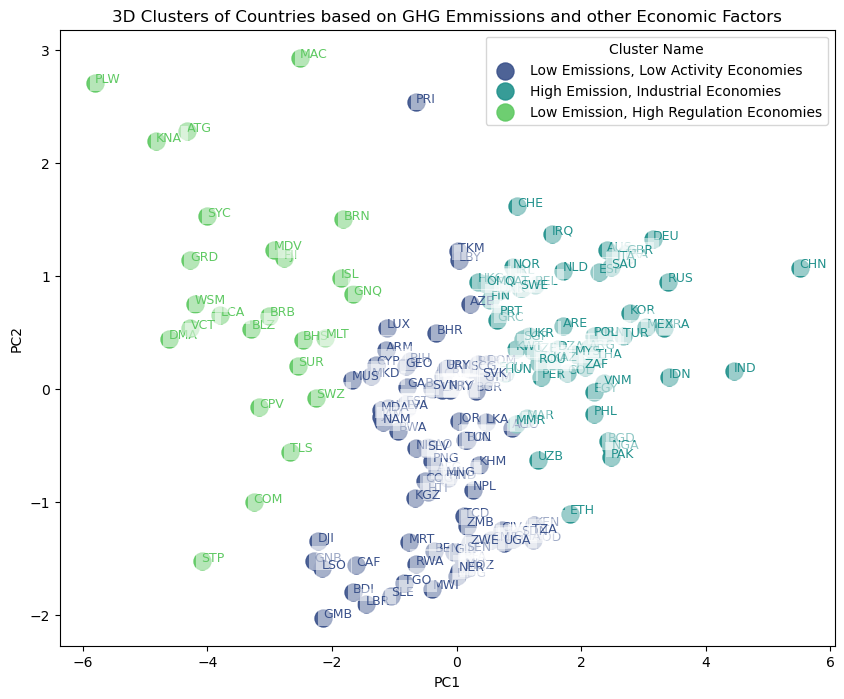

In [45]:

# Define color palette and map cluster names to colors
palette = sns.color_palette('viridis', n_colors=len(cluster_names))
cluster_colors = dict(zip(cluster_names.values(), palette))

# Plot axis
plt.figure(figsize=(10, 8))

# Plot points 
for cluster_name, color in cluster_colors.items():
    subset = principal_df[principal_df['Cluster Name'] == cluster_name]
    plt.scatter(
        subset['PC1'], subset['PC2'],
        color=color, label=cluster_name, s=150, alpha=0.9
    )

# Annotate the plot with country codes
for i in range(principal_df.shape[0]):
    plt.text(
        x=principal_df['PC1'].iloc[i], 
        y=principal_df['PC2'].iloc[i], 
        s=principal_df['Country Code'].iloc[i], 
        fontdict=dict(color=cluster_colors[principal_df['Cluster Name'].iloc[i]], size=9),
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )

# Add legend for clusters
plt.legend(
    title='Cluster Name', 
    loc='upper right', 
    frameon=True
)

# Final plot adjustments
plt.title('3D Clusters of Countries based on GHG Emmissions and other Economic Factors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

The plot displays three clusters based on our specifications, Russia and China are among the High Emission, Industrial Economies, while Uganda and Luxembourg are among the Low Emissions, Low Activity Economies and Maldives and Palau are among the Low Emission, High Regulation Economies. We will be plotting a 3D plot for additional perspective.

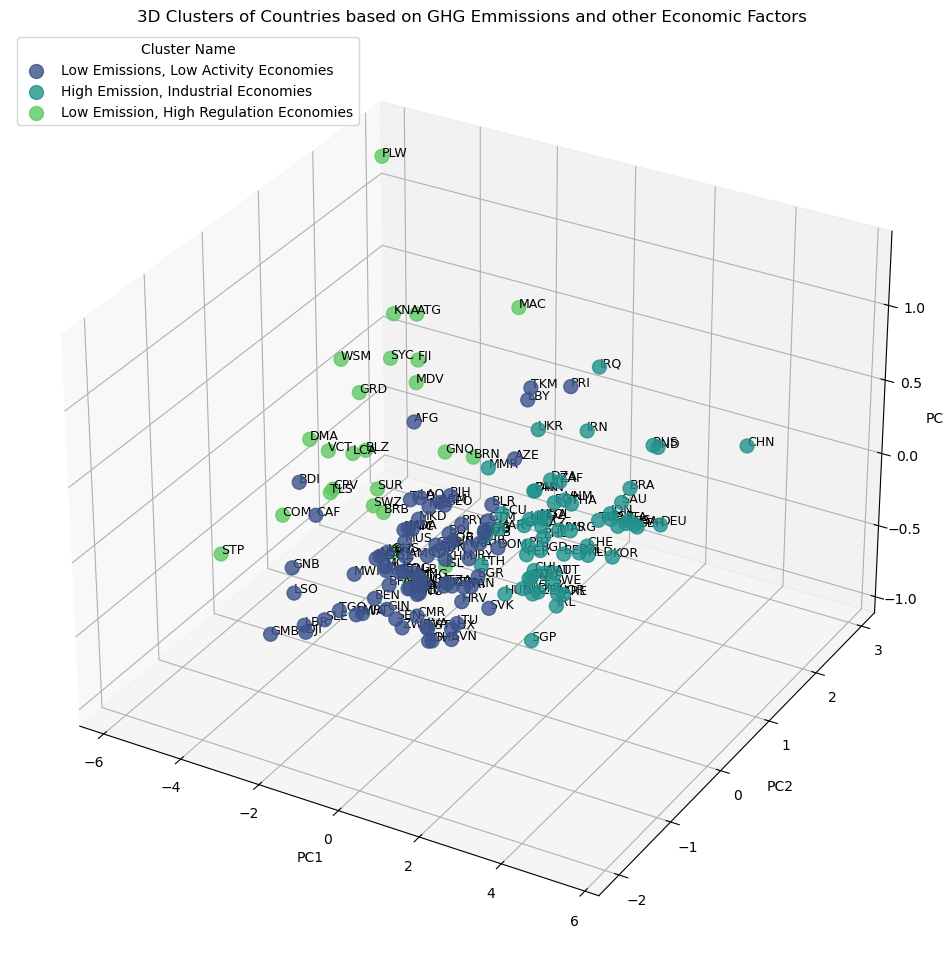

In [48]:
# 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot the points for each cluster
for cluster_name, color in cluster_colors.items():
    subset = principal_df[principal_df['Cluster Name'] == cluster_name]
    ax.scatter(
        subset['PC1'], subset['PC2'], subset['PC3'], 
        color=color, label=cluster_name, s=100, alpha=0.8
    )

# Annotate points with country codes
for i in range(principal_df.shape[0]):
    ax.text(
        x=principal_df['PC1'].iloc[i], 
        y=principal_df['PC2'].iloc[i], 
        z=principal_df['PC3'].iloc[i],
        s=principal_df['Country Code'].iloc[i],
        fontsize=9
    )

# Add legend
ax.legend(title='Cluster Name', loc='upper left')

# Set plot labels
ax.set_title('3D Clusters of Countries based on GHG Emmissions and other Economic Factors')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Show the plot
plt.show()

The 3D plot displays the 3 clusters of countries based on their Greenhouse gas emmissions and in addition also displays the relationship with the third principal component, this helps us understand how the countries are grouped across the three components.

### Conclusion

The study grouped countries based on their Greenhouse gas emmissions and other key economic factors for the year 2023, using Principal Component Analysis (PCA) and K-Means clustering. Although other methods like Multi Dimension Scaling(MDS) and Density-Based Spatial Clustering(DBSCAN) can also be used for clustering, PCA and K-Means were used for their simplicity and scalability.

This approach succesfully categorized the countries and provided key insights. FFuture studies could further investigate the industries contributing most to greenhouse gas emissions, revealing deeper insights.

Data Source: https://edgar.jrc.ec.europa.eu/report_2023, https://databank.worldbank.org/source/world-development-indicators#

Reference: 
Crippa M., Guizzardi D., Pagani F., Banja M., Muntean M., Schaaf E., Becker, W., Monforti-Ferrario F., Quadrelli, R., Risquez Martin, A., Taghavi-Moharamli, P., Grassi, G., Rossi, S., Melo, J., Oom, D., Branco, A., San-Miguel, J., Manca, G., Pisoni, E., Vignati, E., Pekar, F., GHG emissions of all world countries – JRC/IEA 2024 Report, Luxembourg, 2024, https://data.europa.eu/doi/10.2760/4002897, JRC138862.


OpenAI. (2025). ChatGPT (Version 4) [Large language model]. https://openai.com/chatgpt


GitHub. (2025). GitHub Copilot (Version 1) [AI-powered code completion tool]. https://copilot.github.com